# Shor's Algorithm

&nbsp;

## Contents

&nbsp;

1. [Shor's Algorithm](#sa)
    1. [Problem](#pb)
    2. [Protocol](#pt)
    3. [Implementation](#i)
    4. [Classical Post-processing](#cpp)


**Module Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)
    return result_counts

## 1. Shor's Algorithm<a id ='sa'></a>

Shor’s algorithm is famous for factoring integers in polynomial time. 

### A. The problem <a id='pb'></a>

Facturing a number $N=pq$, where $p$,$q$ are prime and large numbers.
* classically - $O (\exp[c \cdot n ^{\frac{1}{3}} (\log n )^{\frac{2}{3}}])$, using the best known methods. 
* Shor's algorithm - is a little faster than $O (n^3)$.

A factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too.

#### Modular arithmetics



$5 / 3 \rightarrow quotient =1 ; remainder 2 $ 

$5  \equiv  2 (\mod 3)$

Generally, $x \equiv y (\mod 3)  \Rightarrow  x = 3k + y $ for some $k \in Z$

Notice the **periodicity** of modular arithmatic!

e.g.
![example_periodic_function](https://physicsmindboggler.co/wp-content/uploads/2020/10/Screenshot-2020-10-26-212025-1.png)

$x \equiv y (\mod N)$ means $y \in \{0,..., N-1\}$




### B. Protocol <a id ='pt'></a> 

$$N = pq$$

1. Pick a number "a" that is a coprime with $N$. 
*Note - $a$ and $b$ are **coprime** if the only positive integer that is a divisor of both of them is 1*
$$(\equiv gcd(a,N)=1)$$

2. find the "order" $r$ of the function $a^r (\mod N)$. 

($\equiv$ smallest $r$ such that $a^r \equiv 1 (\mod N))$

*The "order" is the period of the function*.

3. 
    * if $r$ is even: $$x\equiv a^\frac{r}{2} (\mod N)$$
        * if $x+q \ne 0 (\mod N)$ then:
            * at leat one of the values, $\{p,q\}$, is contained in $\{ \gcd (x+1,N) ,\gcd (x-1),N\}$
    * else: find another "a"

### C. Implemenation <a id='i'></a>

We will focus on the quantum part of Shor’s algorithm, which actually solves the problem of period finding. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of $a^x \mod N$ efficiently, then we can also efficiently factor.

<!--![shor](https://qiskit.org/textbook/ch-algorithms/images/shor_circuit_1.svg)-->


Shor’s solution was to use quantum phase estimation on the unitary operator:
$$U|y\rangle \equiv |ay \mod N \rangle$$

Quantum circuit to factoring $15$.

Let "a" be $13$. 

In [3]:
a=13

In [4]:
if a not in [2,7,8,11,13]:
    raise ValueError("'a' must be 2,7,8,11 or 13")

In [5]:
n_count = 4

**Step 0** 

$15 =[1111]$ start two sets of 4 qubits

$$|x\rangle |w\rangle = |0\rangle ^{\otimes 4}|0\rangle ^{\otimes 4} $$

In [6]:
qc = QuantumCircuit(2*n_count, 2*n_count)

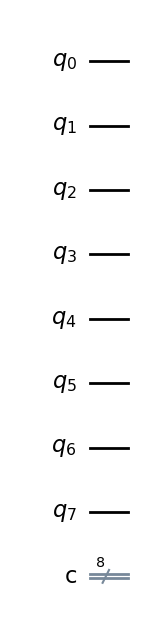

In [7]:
qc.draw(output='mpl')

**Step 1**

Perform Hadamards on the control bits.

$$[H^{\otimes 4} |0\rangle ^{\otimes 4}] |0\rangle^{\otimes 4}$$

$$\frac{1}{4} [|0\rangle_4 + |1\rangle_4 + |2\rangle_4 + ... + |15\rangle_4]|0\rangle_4$$

In [8]:
for q in range(n_count):
    qc.h(q)     # Initialise counting qubits in state |+>

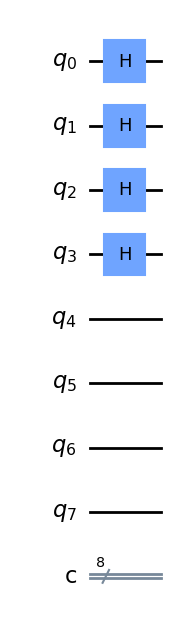

In [9]:
qc.draw(output='mpl')

**Step 2**

Apply the Control $U_{f_{a,N}}$.

$|x\rangle |w\rangle \rightarrow |x\rangle |w \oplus f_{a,N}(x)\rangle$ where  $f_{a,N}(x) \equiv a^x(\mod N)$

$$\frac{1}{4}[|0\rangle_4 |0\oplus 13^0 (\mod 15)\rangle_4+|1\rangle_4 |0\oplus 13^1 (\mod 15)\rangle_4 + ...]$$

Since $0 \oplus Z =Z$

$$=\frac{1}{4}[|0\rangle_4|1\rangle_4 +|1\rangle_4 |13\rangle_4+|2\rangle_4|4\rangle_4 +|3\rangle_4 |7\rangle_4$$
$$ + |4\rangle_4 |1\rangle_4 + |5\rangle_4 |13\rangle_4 + |6\rangle_4 |4\rangle_4  +|7\rangle_4 |7\rangle_4 $$
$$ + |8\rangle_4 |1\rangle_4 + |9\rangle_4 |13\rangle_4 +|10\rangle_4 |4\rangle_4 + |11\rangle_4 |7\rangle_4 $$
$$ + |12\rangle_4 |1\rangle_4 + |13\rangle_4 |13\rangle_4 +|14\rangle_4 |4\rangle_4 +|15\rangle_4 |7\rangle_4 ]$$

<div class="alert alert-block alert-info">
    
**Quantum circuits as (controlled) multi-qubit gates**

&nbsp;

Notice the python function takes no input and returns a `QuantumCircuit` object with 4 qubits. In the past the functions you created might have modified an existing circuit, but a function like this allows us to turn the `QuantumCircuit` object into a single gate we can then control.

We can use `.to_gate()` and `.control()` to create a controlled gate from a circuit.

These custom gates can then be added to the circuit using the `.append(gate, qargs = [qubits])` method on the `QuantumCircuit` object.

</div>

[Tip here](https://www.semanticscholar.org/paper/Comment-on-%22Realization-of-a-scalable-Shor-Cao-Liu/edb06556b7dc87fd91137909dbe35c7106b73261/figure/0)

In [10]:
def Uf(a, power):
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

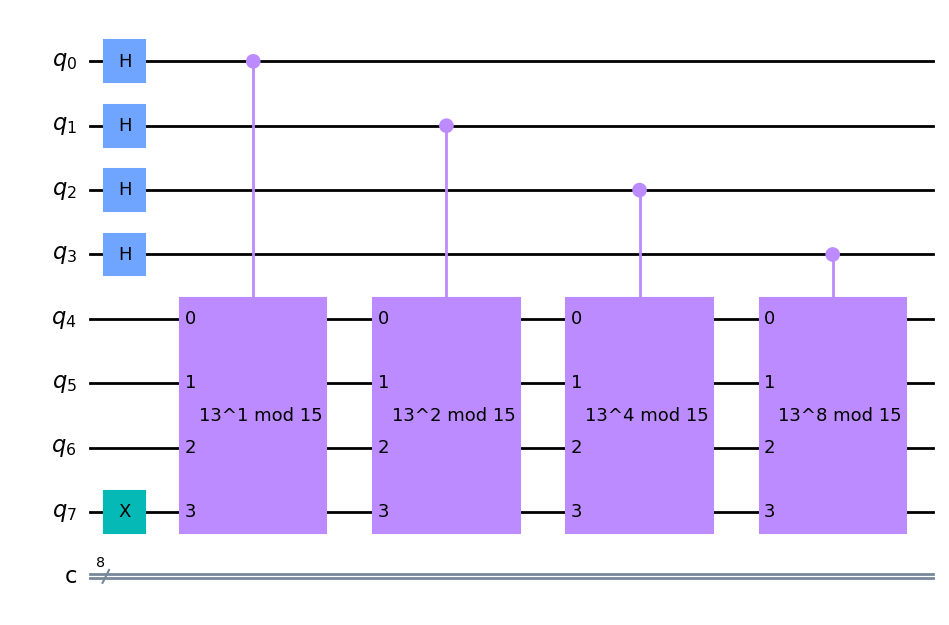

In [11]:
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(Uf(a, 2**q), [q] + [i+n_count for i in range(4)])

qc.draw(output='mpl')

**Step 3** Measure the registers $w$.

Let's say we measure $7$:

$$\frac{1}{2} [|3\rangle_4 + |7\rangle_4+ |11\rangle_4 +|15\rangle_4] \otimes |7\rangle_4$$

In [12]:
for i in range(n_count):
    qc.measure(i+n_count,i+n_count)

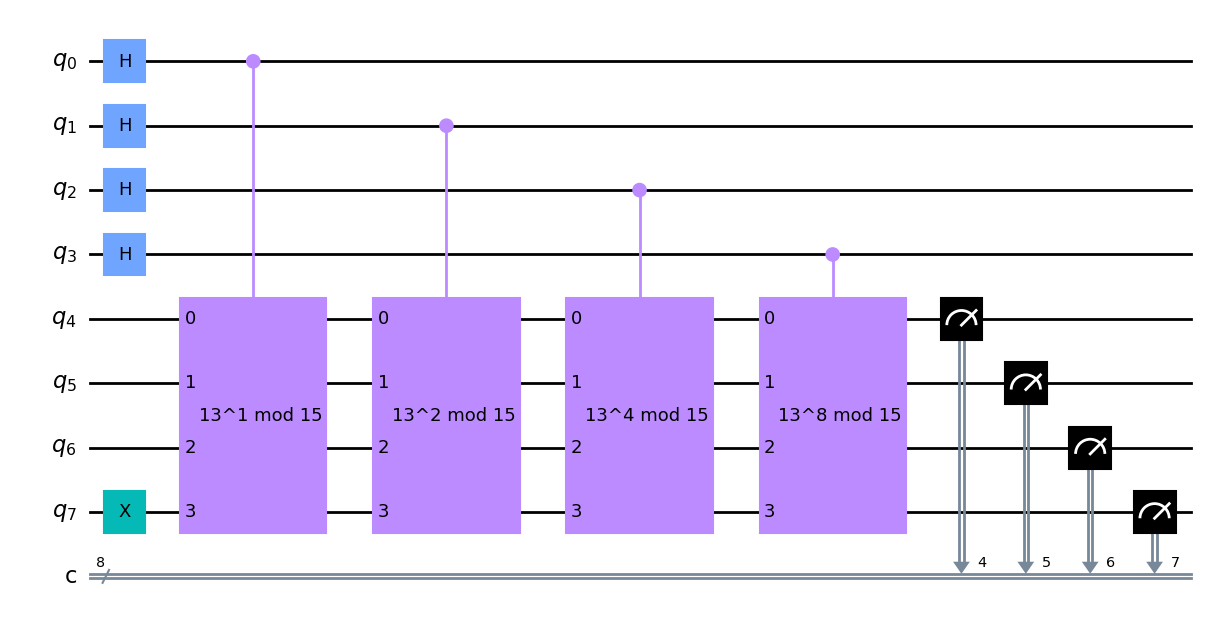

In [13]:
qc.draw(output='mpl')

**Step 4** Apply $QFT^\dagger$ on the register

$$QFT^{\dagger} |\tilde{x} \rangle = |x \rangle \frac{1}{\sqrt{N}}\sum^{N-1}_{y=0} e^{\frac{2 \pi i }{N} x y} | y \rangle$$

In [14]:
pi=np.pi
for y in range(15):
    coeff = np.exp(1j*3*pi/8 *y)+ \
            np.exp(1j*7*pi/8 *y)+ \
            np.exp(1j*11*pi/8 *y)+ \
            np.exp(1j*15*pi/8 *y)
    if abs(coeff) < 1e-10: coeff = 0
    print(y,coeff)

0 (4+0j)
1 0
2 0
3 0
4 (-5.757077917265737e-15-4j)
5 0
6 0
7 0
8 (-4+1.1514155834531474e-14j)
9 0
10 0
11 0
12 (2.2600304269997962e-14+4j)
13 0
14 0


$$QFT^\dagger |x\rangle = \frac{1}{8} (4|0\rangle_4+ 4i|4\rangle_4 -4|8\rangle_4 -4i|12\rangle_4)$$

In [15]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

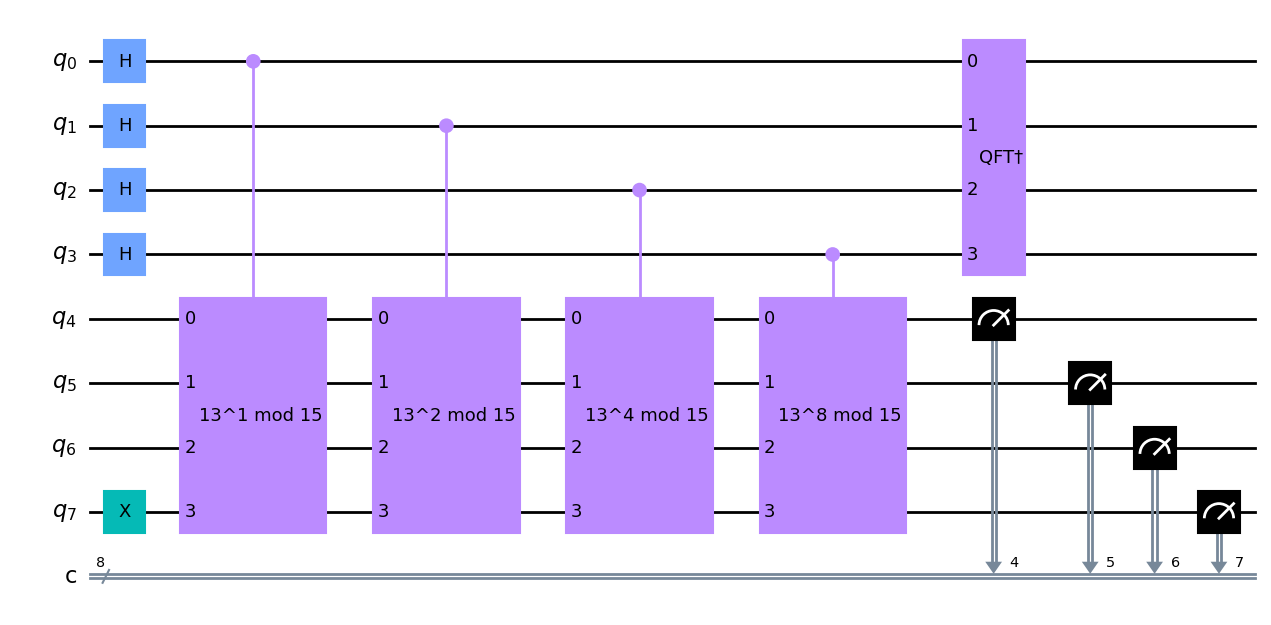

In [16]:
# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

qc.draw(output='mpl')

Measurement results should be $$\{0,4,8,12\}$$ 

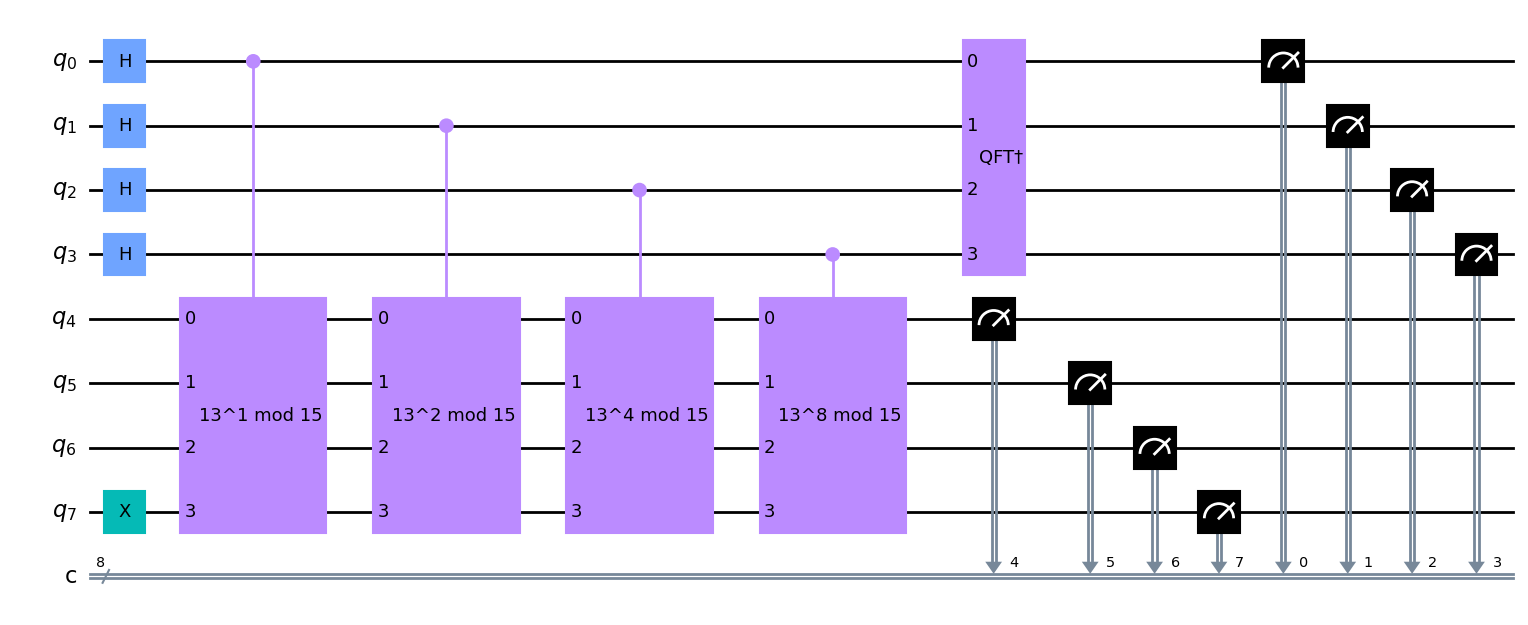

In [17]:
# Measure circuit
qc.measure(range(n_count), range(n_count))


qc.draw(output='mpl')

simulation: 

 {'10000100': 61, '00101100': 74, '11101100': 64, '11101000': 61, '11100100': 62, '00100000': 55, '10110100': 77, '00100100': 61, '00101000': 60, '11100000': 74, '10000000': 51, '10111000': 72, '10001100': 57, '10001000': 67, '10111100': 68, '10110000': 60}


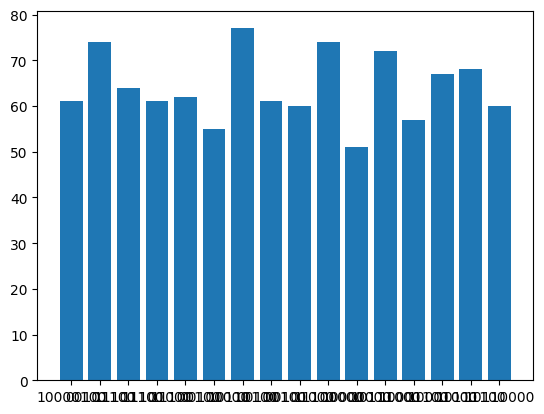

In [18]:
a = execute_locally(qc)

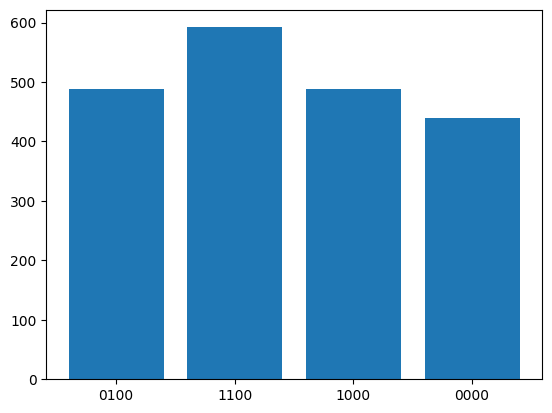

In [19]:
d = dict()
for k in a.keys():
    s = k[4:]
    if s in d:
        c = d.get(k[4:])
        d[s] = d[s]+c
    else:
        d[s]=a[k]

show_results(d)   

### D. Classical Post-processing <a id='cpp'></a>

In [20]:
a=13
for i in d.keys():
    m=int(i,2)
    print('\nmeasured value:', m)
    N=16
    aux = (m/N).as_integer_ratio()
    
    if aux[0] == 0 or aux[1] == 0:
        print('is trivial, restart')
    elif (aux[1]%2)==0:
        print('r is even, we can obtain {p,q}')
        k = int(aux[1]/2)
        x = (a**k)%15
        p=math.gcd(x+1,15)
        q=math.gcd(x-1,15)  
        print('RESULT:', p,q)
    else:
        print('r is odd, restart')


measured value: 4
r is even, we can obtain {p,q}
RESULT: 5 3

measured value: 12
r is even, we can obtain {p,q}
RESULT: 5 3

measured value: 8
r is even, we can obtain {p,q}
RESULT: 1 3

measured value: 0
is trivial, restart


**Refs:**
    
* [Shor's algorithm qiskit school](https://raw.githubusercontent.com/qiskit-community/intro-to-quantum-computing-and-quantum-hardware/master/lectures/introqcqh-lecture-notes-4.pdf)
* [Shor's algorithm YouTube](https://learn.qiskit.org/summer-school/2020/shors-algorithm-ii-from-factoring-to-period-finding-writing-program)
* [Shor's algorithm qiskit](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb)
* [Shor's algorithm wiki](https://en.wikipedia.org/wiki/Shor%27s_algorithm)
